# Safety Signal Detection

**Purpose**: Identify unusual patterns in adverse events  
**Data**: 2020-2023 (4 years)  
**Target Audience**: Advanced researchers, safety surveillance

## What is Signal Detection?

Signal detection identifies potential safety issues by looking for:
- Sudden spikes in event counts
- Changes in event type proportions
- Emerging failure modes in narratives

## Important Note

This notebook demonstrates **exploratory techniques**. Statistical signals require clinical validation and proper epidemiological study design.

In [13]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path().resolve().parent / 'src'))

from pymaude import MaudeDatabase
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

pd.set_option('display.max_columns', None)

In [14]:
db = MaudeDatabase('getting_started.db', verbose=True)

db.add_years(
    years='2020-2023',
    tables=['device', 'master'],
    download=True,
    data_dir='./maude_data'
)


Grouping years by file for optimization...

  Using cached device2020.zip
  Using cached device2021.zip
  Using cached device2022.zip
  Using cached device2023.zip
  Using cached mdrfoithru2025.zip

Processing data files...

device for year 2020 already loaded and unchanged, skipping

device for year 2021 already loaded and unchanged, skipping

device for year 2022 already loaded and unchanged, skipping

device for year 2023 already loaded and unchanged, skipping

master for years 2020-2023 already loaded and unchanged, skipping

Creating indexes...

Database update complete


## 1. Temporal Analysis: Detect Spikes

Look for months with unusually high event counts.

In [15]:
# Query device of interest
device_name = 'insulin pump'
results = db.query_device(device_name=device_name)
print(f"Total events: {len(results):,}")

# Convert dates and group by month
results['date'] = pd.to_datetime(results['DATE_RECEIVED'], errors='coerce')
results['year_month'] = results['date'].dt.to_period('M')

monthly = results.groupby('year_month').size()
print(f"\nMonthly event counts:")
print(monthly.tail(12))

Total events: 827,012

Monthly event counts:
year_month
2023-01    20743
2023-02    17417
2023-03    20315
2023-04    19774
2023-05    18946
2023-06    20515
2023-07    18534
2023-08    22164
2023-09    17271
2023-10    20387
2023-11    19963
2023-12    19542
Freq: M, dtype: int64



Months exceeding threshold (28963 events):
year_month
2022-03    29562
2022-06    39457
2022-07    38850
Freq: M, dtype: int64


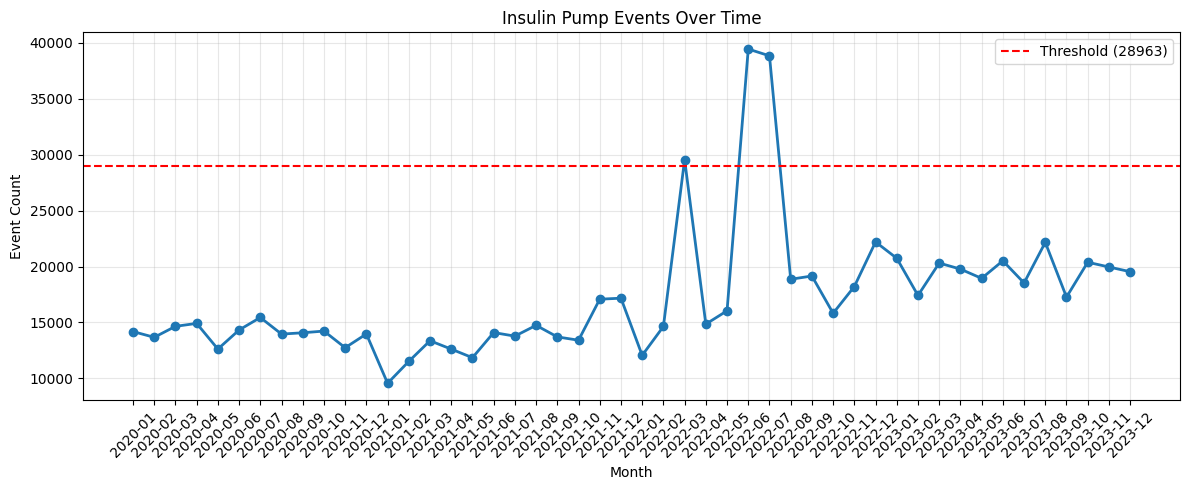

In [16]:
# Detect spikes using statistical threshold
mean = monthly.mean()
std = monthly.std()
threshold = mean + 2*std  # 2 standard deviations

spikes = monthly[monthly > threshold]
print(f"\nMonths exceeding threshold ({threshold:.0f} events):")
print(spikes)

# Visualize
plt.figure(figsize=(12, 5))
plt.plot(monthly.index.astype(str), monthly.values, marker='o', linewidth=2)
plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold ({threshold:.0f})')
plt.xlabel('Month')
plt.ylabel('Event Count')
plt.title(f'{device_name.title()} Events Over Time')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 2. Event Type Proportion Changes

Detect if the ratio of deaths/injuries/malfunctions changes over time.

In [17]:
# Calculate event type proportions by year
results['year'] = results['date'].dt.year

yearly_breakdown = []
for year in sorted(results['year'].dropna().unique()):
    year_data = results[results['year'] == year]
    breakdown = db.event_type_breakdown_for(year_data)
    yearly_breakdown.append({
        'Year': int(year),
        'Total': breakdown['total'],
        'Deaths': breakdown['deaths'],
        'Injuries': breakdown['injuries'],
        'Malfunctions': breakdown['malfunctions'],
        'Death_Rate': breakdown['deaths'] / breakdown['total'] if breakdown['total'] > 0 else 0
    })

breakdown_df = pd.DataFrame(yearly_breakdown)
print(breakdown_df)

   Year   Total  Deaths  Injuries  Malfunctions  Death_Rate
0  2020  168803     137     17715        150951    0.000812
1  2021  162908     126     18084        144698    0.000773
2  2022  259730     320     18562        240847    0.001232
3  2023  235571     245     20409        214917    0.001040


## 3. Limitations and Next Steps

**Limitations of this analysis:**
- No adjustment for market growth
- Reporting bias (changes in reporting practices)
- Seasonal effects not considered
- Multiple testing (many comparisons)

**For rigorous signal detection:**
1. Use proper statistical methods (Poisson regression, disproportionality analysis)
2. Adjust for confounders (market size, reporting trends)
3. Validate signals clinically
4. Consider recall/label changes as co-variates

In [18]:
db.close()
print("\n✓ Signal detection complete!")
print("See docs/research_guide.md for best practices.")


✓ Signal detection complete!
See docs/research_guide.md for best practices.
